
# **Exemplo 1: Estados de Bell**
## Neste exemplo vamos ver como criar e executar um circuito simples (Circuito de Bell). 
* ###  Passo 1: Importar as principais livrarias do qiskit.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, providers
from qiskit.quantum_info import Statevector, Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.providers.aer  import  AerSimulator, noise
from qiskit.utils import QuantumInstance
from ibm_quantum_widgets import *
from qiskit.result import QuasiDistribution
from qiskit.extensions import UnitaryGate

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token = '9fa79efa2b5d81d9ca1d5c9f33493ebc19df76d34ba3efeffff31dfce86bf83d7f0e6c527ecb4caaeb34835a429c49ad23f6ed9dc89029dabc2b73786b966663' )

import time 

# Função para verifiacar o status do job submetido
def job_status(job):
    
    for k in range(120):
        status = job.status()
        msg = status.value
        if  status.name in ["DONE", "CANCELLED", "ERROR"]:
            print(msg, end='\r')
            break
        if  status.name in ["QUEUED"]:
            pos = job.metrics()['position_in_queue']
            print(msg +  '  Position is ' + str(pos), end='\r')
            
        time.sleep(2)
             
    return

* ###  Passo 2: Vamos criar o Circuito de Bell (Hadamard seguito de CNOT) 

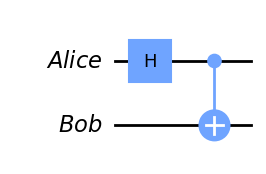

In [2]:
#Vamos criar dois registros, cada um com 1 qubit. Vamos também nomear o Qubit 1 de Alice e 2 de Bob
alice = QuantumRegister(1,'Alice')
bob = QuantumRegister(1,'Bob')
# Vamos criar um circuito com os 2 qubits (Alice e Bob)
circ = QuantumCircuit(alice,bob)
#Vamos adicionar as portas
#Hadamard aplicado em Alice
circ.h(alice)  
#Cnot controle em alice e alvo em bob
circ.cx(alice,bob)
#Vamos visualizar o circuito
circuit_drawer(circ, output='mpl')

In [3]:
#Visualizando a representação matricial do cicuito
U=Operator(circ)
array_to_latex(U.data)

<IPython.core.display.Latex object>

* ### Passo 3: Vamos simular o circuito e visualizar os resultados

In [4]:
# Vamos calcular o estado final do circuito (considerando a entrada com todos os qubits em |0>)
state=Statevector.from_instruction(circ) 
state.draw('latex')

<IPython.core.display.Latex object>

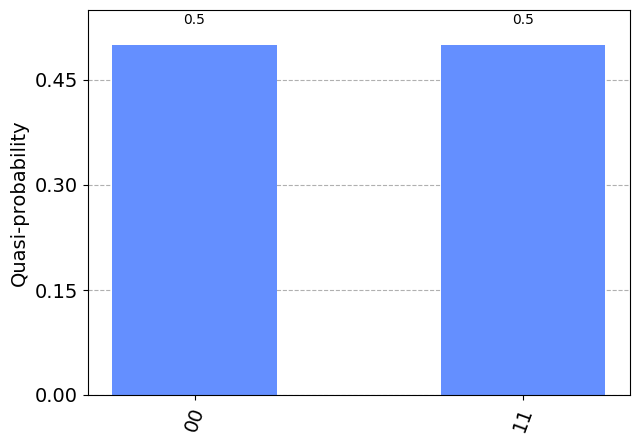

In [5]:
#As probabilidades de obter cada estado após a medição
probs = state.probabilities_dict()
plot_histogram(probs)

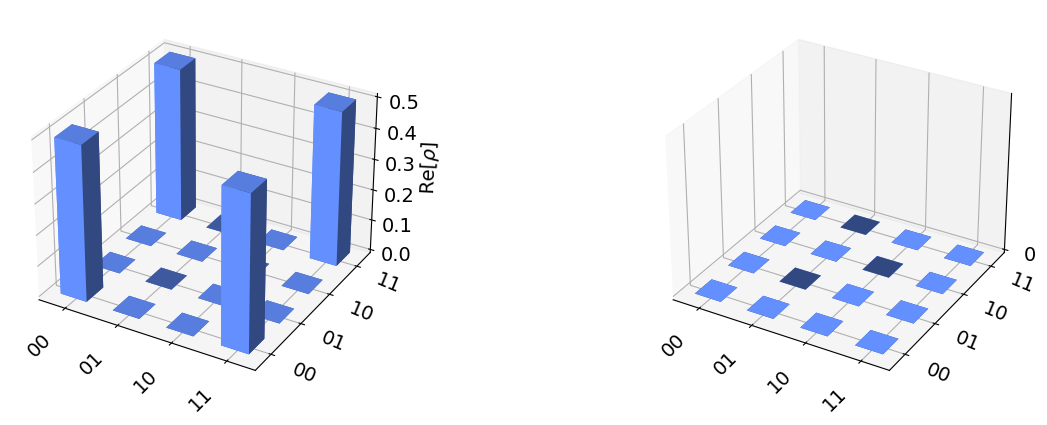

In [6]:
# Estado visualizado como matriz densidade 
state.draw('city')

* ### Agora vamos "simular" a implementação do circuito em um dispositivo real.

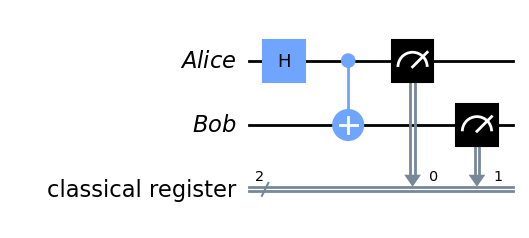

In [6]:
#Para fazer a simlação real precisamos adicionar Medições ao final do circuito. 
#Primeiro criamos dois registros clássicos para guardar a informação de cada medida   
c = ClassicalRegister(2,'classical register')
circ.add_register(c)
#Adicionamos as medidas: A medida de alice (bob) é guardada no qubit 1 (2)
circ.measure(alice ,c[0])
circ.measure(bob ,c[1])
circuit_drawer(circ, output='mpl')

In [7]:
#Escolhemos o simulador "ibmq_qasm_simulator" de propósito geral
backend = service.backend("ibmq_qasm_simulator")
#Vamos esoclher o computador Manila e importar suas caracteristicas
from qiskit.providers.fake_provider import FakeManila
fake_backend = FakeManila()
# Modelo de ruído para o Manila
noise_model = noise.NoiseModel.from_backend(fake_backend)

# número de shots
shots = 5000

# Opções para simualção com ruído.  
options_noise = Options()
options_noise.execution.shots = shots 
options_noise.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
}
sampler_noise = Sampler(backend,options=options_noise)

# Vamos definir as opções para simualção sem ruído. 
options_no_noise = Options()
options_no_noise.execution.shots = shots 
options_no_noise.simulator = {
    "noise_model": None,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
}
sampler_no_noise = Sampler(backend,options=options_no_noise)

In [8]:
#Run job (sem ruído)
job_noise = sampler_noise.run(circ)
#Checamos se o Job terminou
job_status(job_noise)

In [9]:
#Run job (comm ruído)
job_no_noise = sampler_no_noise.run(circ)
#Checamos se o Job terminou
job_status(job_no_noise)

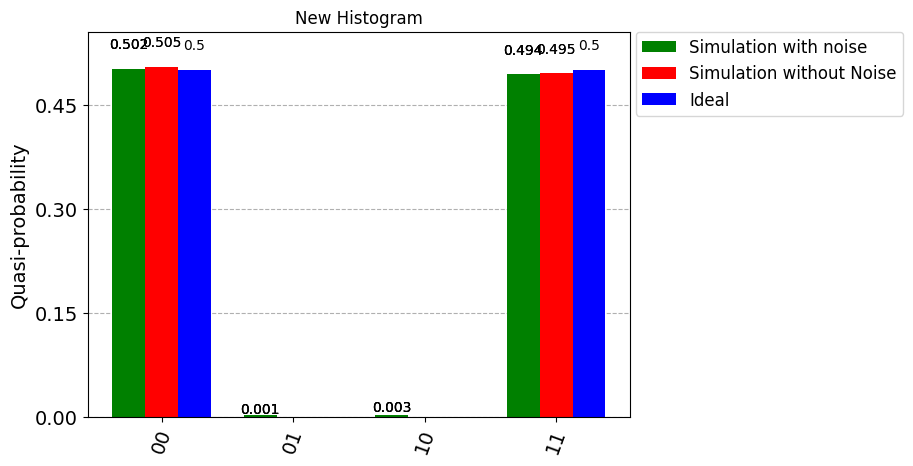

In [10]:
#Agoras vamos comparar os resultados
result_noise=job_noise.result()
result_no_noise=job_no_noise.result()
probs_noise = result_noise.quasi_dists[0].binary_probabilities()
probs_no_noise = result_no_noise.quasi_dists[0].binary_probabilities()
plot_histogram([probs_noise, probs_no_noise, probs], legend=['Simulation with noise', 'Simulation without Noise', 'Ideal'], color=['g','r','b'],
                title="New Histogram")

* ### Agora vamos executar o programa em um computador real. 

In [11]:
backend = service.get_backend('ibmq_manila')
optimized_circ = transpile(circ,backend)
options = Options()
options.execution.shots = shots
sampler = Sampler(backend,options=options)
job = sampler.run(optimized_circ)

In [ ]:
job_status(job)
#job.cancel

/tmp/ipykernel_62/2228154630.py:32: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.quantum_seconds' attribute instead.
  pos = job.metrics()['position_in_queue']


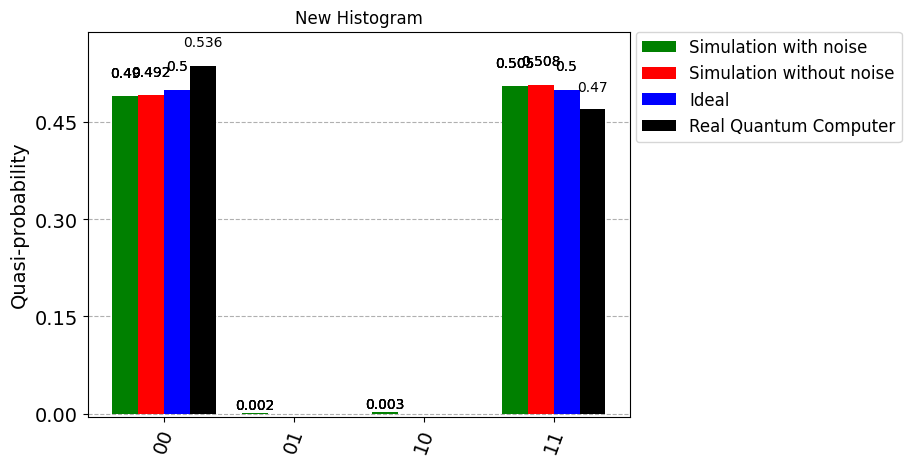

In [179]:
result=job.result()
probs_real = result.quasi_dists[0].binary_probabilities()
plot_histogram([probs_noise, probs_no_noise, probs, probs_real], legend=['Simulation with noise', 'Simulation without noise', 'Ideal', 'Real Quantum Computer'], color=['g','r','b','k'],
                title="New Histogram")

* ### Note que o resultado não é uma distribuição de probabilidades pois o pós-processamento feito para mitigar erros retorna apenas uma quasi-distribuição, cuja soma é 1, porém pode conter probabilidades negativas.

In [180]:
print(probs_real)
print(probs_noise)
print(probs_no_noise)

{'00': 0.5362273006648175, '01': -0.002107850662688967, '10': -0.004152805062127364, '11': 0.47003335505999894}
{'00': 0.4903833561804672, '01': 0.0015338898200353535, '10': 0.0030550740740294697, '11': 0.5050276799254679}
{'00': 0.492, '11': 0.508}


{'11': 0.46690302719759075, '00': 0.5330969728024093}
{'01': 0.0015338898200353535, '10': 0.0030550740740294697, '00': 0.4903833561804672, '11': 0.5050276799254679}


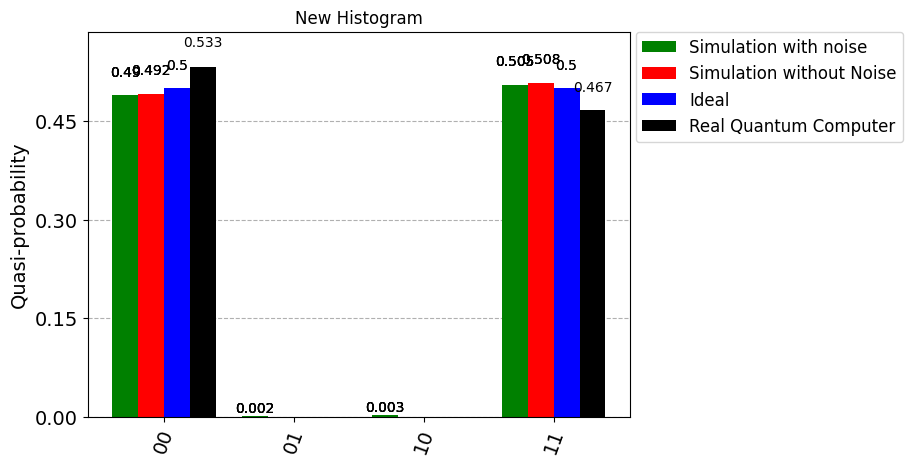

In [181]:
#podemos obter uma distribuição de probabilidades real
aux = QuasiDistribution(probs_real)
probs_real_corrected=aux.nearest_probability_distribution().binary_probabilities()
aux = QuasiDistribution(probs_noise)
probs_noise_corrected=aux.nearest_probability_distribution().binary_probabilities()
print(probs_real_corrected)
print(probs_noise_corrected)
plot_histogram([probs_noise_corrected, probs_no_noise, probs, probs_real_corrected],legend=['Simulation with noise', 'Simulation without Noise', 'Ideal', 'Real Quantum Computer'], color=['g','r','b','k'],
                title="New Histogram")